In [ ]:
from google.colab import drive
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import os

drive.mount('/content/drive', force_remount=False)

DATA_PATH="/content/drive/My Drive/MLFolder/Onlab/Waveform_classical/"

Mounted at /content/drive


In [ ]:
!nvidia-smi

Fri Mar 26 14:19:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
full = []

for idx, file in enumerate(tqdm(os.listdir(DATA_PATH), position=0, leave=True)):
    song, sr = librosa.load(os.path.join(DATA_PATH, file), sr=16000)
    for i in song:
        full.append(i)
    if idx == 0:
        fullnp = np.asarray(full)
    else :
        fullnp = np.concatenate((fullnp, np.asarray(full)))
    full = []

  0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
  8%|▊         | 1/12 [01:30<16:30, 90.06s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 17%|█▋        | 2/12 [02:53<14:41, 88.15s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 25%|██▌       | 3/12 [04:40<14:02, 93.65s/it]/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
 33%|███▎      | 4/12 [06:11<12:23, 92.88s/it]/usr/local/lib/pyt

In [ ]:
print(fullnp.shape)

(388633088,)


In [ ]:
np.save("schubert.npy", fullnp)

Parsing the 12 songs with 16 kHz sampling rate takes around 23 minutes. An alternative can be to save it to a binary .npy file, but it takes up 1.48 Gigabytes of space.

In [ ]:
scaling_factor = np.max(np.abs(fullnp))

In [ ]:
scaled = fullnp / scaling_factor

In [ ]:
from keras.utils import to_categorical

def mulaw_encode(samples):
    # Encode to -128..127. Return 0..255.
    return (librosa.mu_compress(samples, quantize=True) + 128).astype('uint8')

def mulaw_decode(samples):
    # Rescale from 0..255 to -128..127. Decode to -1.0..1.0.
    return (librosa.mu_expand(samples.astype('int16') - 128, quantize=True) )

In [ ]:
encoded = mulaw_encode(scaled)

In [ ]:
print(np.min(encoded))

In [ ]:
from keras.utils import Sequence

SLICE_SIZE = 2000

class MyDatagen(Sequence):
  def __init__(self, list_IDs, batch_size=16, dim=(SLICE_SIZE), shuffle=True, validation=False):
    'Initialization'
    self.dim = dim
    self.batch_size = batch_size
    self.list_IDs = list_IDs
    self.shuffle = shuffle
    self.validation=validation
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.list_IDs) / self.batch_size))

  def __getitem__(self, index):
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Find list of IDs
    list_IDs_temp = [self.list_IDs[k] for k in indexes]

    # Generate data
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  def on_epoch_end(self):
      #Updates indexes after each epoch
    self.indexes = np.arange(len(self.list_IDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self, list_IDs_temp):
    #Generates data containing batch_size samples
    if self.validation:
      X = np.empty((self.batch_size, self.dim))
      y = np.empty((self.batch_size, 256))

      # Generate data
      for i, ID in enumerate(list_IDs_temp):
        X[i] = encoded[ID:ID+SLICE_SIZE]/255.0

        y[i] = to_categorical(encoded[ID+SLICE_SIZE], num_classes=256)

      return X, y
    else:
      X = np.empty((self.batch_size, self.dim))
      y = np.empty((self.batch_size, 256))

      # Generate data
      for i, ID in enumerate(list_IDs_temp):
        X[i] = encoded[ID:ID+SLICE_SIZE]/255.0

        y[i] = to_categorical(encoded[ID+SLICE_SIZE], num_classes=256)

      return X, y

In [ ]:
from keras.layers import Conv1D, Flatten, Dense, Input, Activation, Add, Multiply
from keras.models import Model

# This code served as inspiration:
# https://github.com/usernaamee/keras-wavenet
def wavenet_residual_block(filters, kernel_size, dilation_rate):
    def f(input_):
        conv = Conv1D(filters, kernel_size, 
                      dilation_rate=dilation_rate,
                      padding='same')(input_)
        tanh = Activation('tanh')(conv)
        sigmoid = Activation('sigmoid')(conv)
        merged = Multiply()([tanh, sigmoid])
        out = Conv1D(1, 1, padding='same')(merged)
        residual_out = Add()([out, input_])
        skip_out = Activation('relu')(out)
        return residual_out, skip_out
    return f

def wavenet_convolutional_layers(filters, kernel_size, depth):
    def f(input_):
        residual_out = input_
        skip_connections = []
        for i in range(1, depth+1):
            dilation_rate = 2**(i % 15)
            residual_out, skip_out = wavenet_residual_block(
                filters, kernel_size, dilation_rate)(residual_out)
            skip_connections.append(skip_out)
        sum_ = Add()(skip_connections)
        act = Activation('relu')(sum_)
        return act
    return f

def wavenet(input_size):
    input_ = Input(shape=(input_size, 1))
    net = wavenet_convolutional_layers(128, 3, 30)(input_)
    net = Conv1D(2048, 3, padding='same')(net)
    net = Conv1D(256, 3, padding='same')(net)
    net = Flatten()(net)
    net = Dense(256, activation='softmax')(net)
    model = Model(input_, net)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model


model = wavenet(SLICE_SIZE)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 2000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_124 (Conv1D)             (None, 2000, 128)    512         input_3[0][0]                    
__________________________________________________________________________________________________
activation_182 (Activation)     (None, 2000, 128)    0           conv1d_124[0][0]                 
__________________________________________________________________________________________________
activation_183 (Activation)     (None, 2000, 128)    0           conv1d_124[0][0]                 
____________________________________________________________________________________________

In [ ]:
print(scaled.shape[0]/16)

24872517.8125


In [ ]:
print(24872517 - 4872517)

20000000


In [ ]:
TRAIN_SAMPLES = 200000
VAL_SAMPLES = 40000

training_gen=MyDatagen(range(TRAIN_SAMPLES), batch_size=16)
val_gen=MyDatagen(range(TRAIN_SAMPLES, TRAIN_SAMPLES+VAL_SAMPLES), validation=True)

model.fit(x=training_gen, validation_data=val_gen, epochs=100)

Epoch 1/100
12500/12500 [==============================] - 4029s 322ms/step - loss: 14.2361 - val_loss: 4.2747
Epoch 2/100
12500/12500 [==============================] - 4017s 321ms/step - loss: 11.9660 - val_loss: 4.2062
Epoch 3/100
 2599/12500 [=====>........................] - ETA: 50:15 - loss: 6.3432

In [ ]:
test_gen = MyDatagen(range(20000000, 24872517), validation=True)

model.evaluate(test_gen)

   223/304532 [..............................] - ETA: 7:19:24 - loss: 0.0127

KeyboardInterrupt: ignored

In [ ]:
MODEL_SAVE_PATH = "/content/drive/MyDrive/MLFolder/Onlab/modelsaves/"

model.save(MODEL_SAVE_PATH + "Wavenet1.h5")

In [ ]:
from keras.models import load_model

model = load_model("/content/drive/MyDrive/MLFolder/Onlab/modelsaves/Wavenet1.h5")

In [ ]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    preds = np.squeeze(preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [ ]:
#KELL A SAMPLING, ÍGY SZAR
def make_prediction(model, starting_slice, prediction_length, scaling_factor=1.0):
    pattern = np.asarray(starting_slice)
    pattern = np.atleast_3d(pattern)

    res = []

    for i in tqdm(range(prediction_length), position=0, leave=True):
        nextvalue = model.predict(pattern, batch_size=1)
        nextvalue = sample(nextvalue, 2.0)/255.0
        pattern = np.append(pattern, nextvalue)
        pattern = pattern[1:len(pattern)]
        pattern = np.atleast_3d(pattern)
        res.append(nextvalue)

    return mulaw_decode(np.asarray(res)) * scaling_factor

In [ ]:
SR = 16000
SECONDS = 2
PRED_LEN = SR*SECONDS

predicted = make_prediction(model, encoded[30000000:30000000+SLICE_SIZE]/255.0, PRED_LEN, np.max(fullnp))

  0%|          | 0/32000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
100%|██████████| 32000/32000 [23:25<00:00, 22.76it/s]


In [ ]:
print(predicted.shape)

(32000,)


In [ ]:
print(np.max(predicted))

-0.9063299894332886


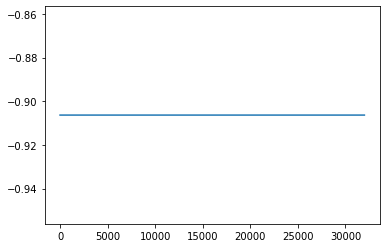

In [ ]:
import matplotlib.pyplot as plt

plt.plot(predicted)
plt.show()

In [ ]:
from IPython.lib.display import Audio

Audio(np.squeeze(predicted), rate=16000, autoplay=False)

In [ ]:
import gc

gc.collect()